In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
from matplotlib import pyplot as plt
#import corner
import urllib
import os
import sys
#import GCRCatalogsF
from astropy.io import fits
#from demo_funcs_local import *
from sklearn.model_selection import train_test_split
import pandas as pd
from astropy.cosmology import Planck15 as P15
from astropy import units as u
import seaborn as sns
import pandas as pd

In [11]:
sns.set_context("talk")

sns.set(font_scale=2.5)
sns.set_style("white")
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 40})
sns.set_style("ticks", {"xtick.minor.size": 8, "ytick.minor.size": 8})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
## for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

sns.set_style('white', {'axes.linewidth': 1.0})
plt.rcParams['xtick.major.size'] = 15
plt.rcParams['ytick.major.size'] = 15

plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['ytick.minor.size'] = 10
plt.rcParams['xtick.minor.width'] = 2
plt.rcParams['ytick.minor.width'] = 2

plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.right'] = True

plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

In [12]:
fnIa = "./matchedGals_IaGhostlib.tar.gz"
fnII = "./matchedGals_IIGhostlib.tar.gz"

dc2_Ia = pd.read_csv(fnIa)
dc2_II = pd.read_csv(fnII)

In [13]:
dc2_Ia['GHOST_transientclass'] = 'SN Ia'
dc2_II['GHOST_transientclass'] = 'SN II'

dc2_full = pd.concat([dc2_Ia, dc2_II],ignore_index=True)

In [20]:
dc2_full['size_minor_true_x'].dropna()

0        1.383557
1        2.951802
2        4.947244
3        0.754545
4        0.427763
           ...   
48255    0.441248
48256    0.648032
48257    0.057959
48258    0.230736
48259    0.050416
Name: size_minor_true_x, Length: 48260, dtype: float64

In [25]:
#dc2_full['size_minor_true'] = dc2_full['size_minor_true_x']
#del dc2_full['size_minor_true_x']
#del dc2_full['size_minor_true_y']

dc2_full['position_angle_true'] = dc2_full['position_angle_true_x']
del dc2_full['position_angle_true_x']
del dc2_full['position_angle_true_y']

In [26]:
dc2_full.columns.values

array(['galaxy_id', 'ra', 'dec', 'PZflowredshift', 'DC2redshift',
       'totalEllipticity', 'PZflowSFRtot', 'DC2SFRtot',
       'Mag_true_g_sdss_z0', 'Mag_true_r_sdss_z0', 'Mag_true_i_sdss_z0',
       'Mag_true_z_sdss_z0', 'totalSersicIndex', 'sersic_disk',
       'sersic_bulge', 'size_bulge_true', 'size_minor_bulge_true',
       'size_disk_true', 'size_minor_disk_true', 'stellar_mass',
       'GHOST_objID', 'GHOST_transientclass', 'GHOST_ra', 'GHOST_dec',
       'nn_distance', 'mag_true_g_lsst', 'size_true', 'mag_true_r_lsst',
       'mag_true_z_lsst', 'mag_true_i_lsst', 'z_bin', 'Mag_true_g_lsst',
       'Mag_true_r_lsst', 'Mag_true_i_lsst', 'Mag_true_z_lsst',
       'size_minor_true', 'position_angle_true'], dtype=object)

In [27]:
SN_list = []
for SN in np.unique(dc2_full['GHOST_transientclass'].values):
    SN_list.append(dc2_full[dc2_full['GHOST_transientclass'] == SN])

In [29]:
#g_obs, r_obs
#Size_true, size_minor_true → a0_Sersic, b0_Sersic
#Sersic index → n0_Sersic
#Position_angle_true → a_rot Martine: figure out if this is the same
    
SNCount = {}

for dc2 in SN_list:
    SN = dc2['GHOST_transientclass'].values[0]
    SN = SN.replace("/", "")
    DF = pd.DataFrame({'VARNAMES:':['GAL:']*len(dc2['stellar_mass'].values), 
                   'GALID':dc2['galaxy_id'].values, 
                    'galaxy_id':dc2['galaxy_id'].values,
                    'RA_GAL':dc2['ra'].values,
                    'DEC_GAL':dc2['dec'].values,
                   'ZTRUE':dc2['PZflowredshift'].values, 
                   'PZflowredshift':dc2['PZflowredshift'].values,
                   'DC2redshift':dc2['DC2redshift'].values, 
                   'g_obs':dc2['Mag_true_g_lsst'].values, 
                   'r_obs':dc2['Mag_true_r_lsst'].values, 
                   'i_obs':dc2['Mag_true_i_lsst'].values, 
                   'z_obs':dc2['Mag_true_z_lsst'].values, 
                   'a0_Sersic':dc2['size_true'].values, 
                   'size_true':dc2['size_true'].values, 
                   'b0_Sersic':dc2['size_minor_true'].values, 
                   'size_minor_true':dc2['size_minor_true'].values, 
                   'n0_Sersic':dc2['totalSersicIndex'].values,
                   'totalSersicIndex':dc2['totalSersicIndex'].values, 
                   'a_rot':dc2['position_angle_true'].values,
                   'position_angle_true':dc2['position_angle_true'].values,
                   'TOTAL_ELLIPTICITY':dc2['totalEllipticity'].values,
                   'LOGMASS_TRUE':np.log10(dc2['stellar_mass'].values), 
                   'LOGMASS':np.log10(dc2['stellar_mass'].values), 
                   'LOGMASS_OBS':np.log10(dc2['stellar_mass'].values), 
                   'stellar_mass':dc2['stellar_mass'].values, 
                   'STAR_FORMATION_RATE':dc2['PZflowSFRtot'].values, 
                   'PZflowSFRtot':dc2['PZflowSFRtot'].values, 
                   'DC2SFRtot':dc2['DC2SFRtot'].values, 
                   'Mag_true_g_sdss_z0':dc2['Mag_true_g_sdss_z0'].values,
                   'Mag_true_r_sdss_z0':dc2['Mag_true_r_sdss_z0'].values,
                   'Mag_true_i_sdss_z0':dc2['Mag_true_i_sdss_z0'].values,
                   'Mag_true_z_sdss_z0':dc2['Mag_true_z_sdss_z0'].values,
                   'GHOST_objID':dc2['GHOST_objID'].values,
                   'GHOST_ra':dc2['GHOST_ra'].values,
                   'GHOST_dec':dc2['GHOST_dec'].values,
                   'GHOST_transientclass':dc2['GHOST_transientclass'].values,
                   'sersic_disk':dc2['sersic_disk'].values,
                   'sersic_bulge':dc2['sersic_bulge'].values,
                   'nn_distance':dc2['nn_distance'].values,
                   'size_bulge_true':dc2['size_bulge_true'].values,
                   'size_minor_bulge_true':dc2['size_minor_bulge_true'].values,
                   'size_disk_true':dc2['size_disk_true'].values,
                   'size_minor_disk_true':dc2['size_minor_disk_true'].values,
                   'mag_true_g_lsst':dc2['mag_true_g_lsst'].values,
                   'mag_true_r_lsst':dc2['mag_true_r_lsst'].values,
                   'mag_true_i_lsst':dc2['mag_true_i_lsst'].values,
                   'mag_true_z_lsst':dc2['mag_true_z_lsst'].values,
                   'Mag_true_g_lsst':dc2['Mag_true_g_lsst'].values,
                   'Mag_true_r_lsst':dc2['Mag_true_r_lsst'].values,
                   'Mag_true_i_lsst':dc2['Mag_true_i_lsst'].values,
                   'Mag_true_z_lsst':dc2['Mag_true_z_lsst'].values})
    SNCount[SN] = len(DF)
    #combine with original to get same names out
    DF_merged = pd.merge(DF, dc2_full,on='galaxy_id')
    DF_merged.drop_duplicates(subset=['GALID'], inplace=True)
    DF_merged.to_csv("%s_G.HOSTLIB"%SN.replace(" ", ""),index=False, sep=' ')

In [30]:
DF_merged['g_obs']

0       -14.426647
1       -18.992457
2       -19.735573
3       -15.694560
4       -15.349243
           ...    
41110   -18.374923
41111   -19.018665
41112   -15.740648
41113   -19.322194
41114   -22.840325
Name: g_obs, Length: 36651, dtype: float64

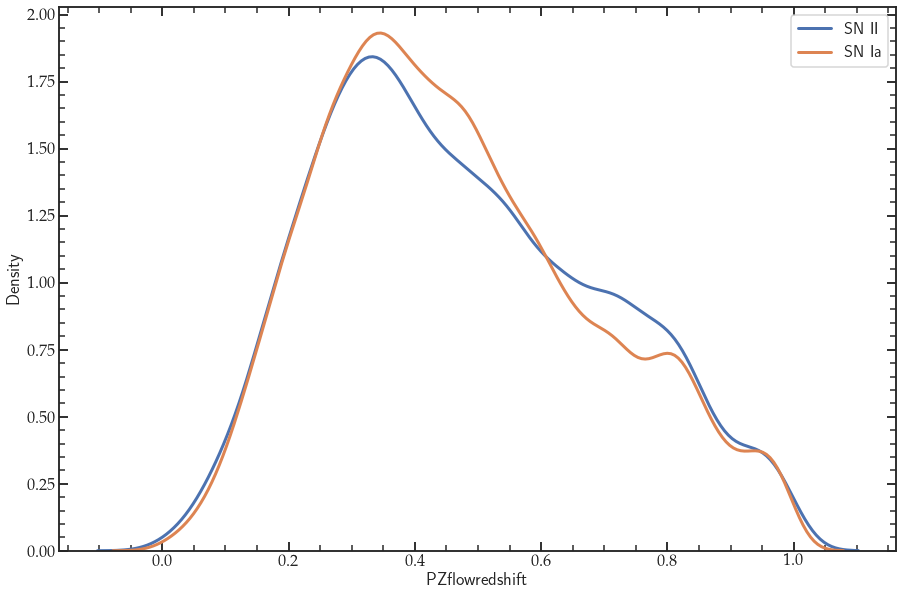

In [31]:
sns.set_context("talk")
plt.figure(figsize=(15,10))

i = 0
cols = sns.color_palette()
for SN in np.unique(dc2_full['GHOST_transientclass']):
    dc2_temp = dc2_full[dc2_full['GHOST_transientclass'] == SN]
    sns.kdeplot(data=dc2_temp, x="PZflowredshift",lw=3, label=SN, color=cols[i])
    i += 1
#plt.yscale("log")
plt.legend()
#plt.savefig("7Class_HostlibHist_FracHist_NewMatching_10pct.png",bbox_inches='tight', dpi=300)